# Convolutional 2D VAE

In [1]:
from google.colab import drive
drive.mount("/content/drive/")

%cd drive/MyDrive/Colab\ Notebooks/

Mounted at /content/drive/
/content/drive/MyDrive/Colab Notebooks


Import necessary packages

In [2]:
from glob import glob
import numpy as np
from scipy.spatial.distance import pdist, squareform
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import linalg as la
from keras import regularizers
from keras import backend as K
from keras.layers import (
    Conv2D,
    Conv2DTranspose,
    Input,
    Flatten,
    Dense,
    Lambda,
    Reshape,
)

## Data Input and Pre-Processing

Define core features of the dataset.

In [3]:
dim = 2
numpart = 30
latent_dim = 40
box_size = 10

Import and reshape data.

In [4]:
dump_dir = "./dump/"
# read all position files in chosen directory
files = glob(dump_dir + "gamma*_10000_*_x.txt")
# sort files by gamma value
files = np.array(files)[np.argsort([f.split("_")[1] for f in files])]
gamma = np.sort([f.split("_")[1] for f in files]).astype(float)

# if different from zero, you can pick a single file with a specific gamma
choose_one_gamma = 0

if choose_one_gamma != 0:
    gamma = choose_one_gamma
    num_gammas = 1

    fname = [f for f in files if f.split("_")[1] == str(gamma)][0]
    data = np.loadtxt(fname)
    vcs = data.reshape((-1, numpart, dim)) / (box_size * np.sqrt(dim))
    labels = np.zeros(len(data))
else:
    num_gammas = files.size
    arrays = [np.loadtxt(f) for f in files]

    # combine data + reshape, and assign labels to different datasets
    data = np.vstack(arrays)
    vcs = data.reshape((-1, numpart, dim)) / (box_size * np.sqrt(dim))
    labels = np.hstack([[i] * len(a) for i, a in enumerate(arrays)])

print("Original array shape:", data.shape)
print("Reshaped array shape:", vcs.shape)

Original array shape: (40000, 60)
Reshaped array shape: (40000, 30, 2)


Sort by distance from origin

In [5]:
sort_idx = np.argsort(vcs[:, :, 0] ** 2 + vcs[:, :, 1] ** 2)
sorted_vcs = np.array(
    [sample[sort_idx[i]] for i, sample in enumerate(vcs)]
)

### Compute distance matrices

In [6]:
# metric="euclidean", force="no", checks=True are by default
dm = np.array([squareform(pdist(sample)) for sample in sorted_vcs])

print("Distance matrix shape:", dm.shape)


Distance matrix shape: (40000, 30, 30)


Split in training and test set

In [7]:
train_perc = 0.8

m = sorted_vcs.shape[0]  # total number of samples
m_training = int(m * train_perc)  # samples in the training set
m_test = m - m_training  # samples in the test set

while True:
    permutation = np.random.permutation(m)

    sorted_vcs = sorted_vcs[permutation]
    labels = labels[permutation]
    dm = dm[permutation]

    trainset_conf = sorted_vcs[:m_training]
    testset_conf = sorted_vcs[m_training:]

    trainset_mat = dm[:m_training]
    testset_mat = dm[m_training:]

    counts = [
        np.count_nonzero(labels[:m_training] == i)
        for i in range(num_gammas)
    ]

    # if each label is represented by at least half of
    # training set size / number of files
    # we're good and we can stop permutating
    if all(c > int(m_training / (2 * num_gammas)) for c in counts):
        break

print("Shape of the training set: ", trainset_conf.shape)
print("Shape of the test set: ", testset_mat.shape)

Shape of the training set:  (32000, 30, 2)
Shape of the test set:  (8000, 30, 30)


## Variational Auto Encoder (Model 1)

### VAE Class

In [8]:
reg_lambda = 0.00035


class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            # Extract dimensions excluding the first 'None' dimension
            size = reconstruction.shape[1:]
            # noise = np.random.normal(0, 0.1, size=size)
            # reconstruction = reconstruction + noise

            # Reshape data to match decoder output shape
            data = tf.expand_dims(data, axis=-1)

            reconstruction_loss = tf.reduce_mean(
                keras.losses.mean_squared_error(data, reconstruction)
            )
            kl_loss = -0.5 * (
                1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            )
            kl_loss = tf.reduce_mean(kl_loss)
            total_loss = reconstruction_loss + reg_lambda * kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }


### Load the trained VAE

In [9]:
encoder = tf.keras.models.load_model("saved_model/encoder")
decoder = tf.keras.models.load_model("saved_model/decoder")

vae = VAE(encoder, decoder)


## Evaluate performance
We'll now use the test set to explore the latent space distribution of data and the reconstruction accuracy

In [10]:
encoded_test = np.array(vae.encoder.predict(testset_mat))
encoded_train = np.array(vae.encoder.predict(trainset_mat))

print(encoded_test.shape)

1000/1000 [==============================] - 57s 57ms/step
(3, 8000, 40)


We can now use the data to decode

In [11]:
decoded_test = np.array(decoder.predict(encoded_test[2, :, :])).reshape(
    -1, numpart, numpart
)
decoded_train = np.array(decoder.predict(encoded_train[2, :, :])).reshape(
    -1, numpart, numpart
)
print(decoded_test.shape)


1000/1000 [==============================] - 126s 126ms/step
(8000, 30, 30)


### Check reconstruction

<Axes: >

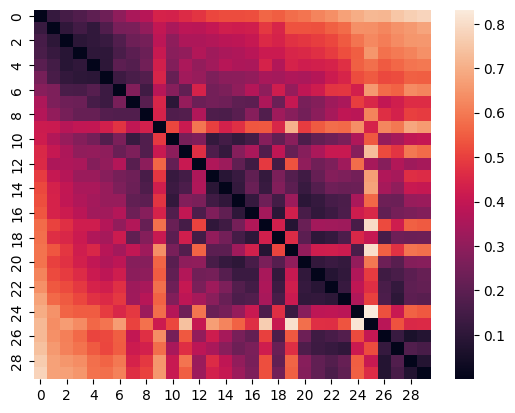

In [12]:
ind = 42
df = pd.DataFrame(decoded_test[ind])
sns.heatmap(data=df)


<Axes: >

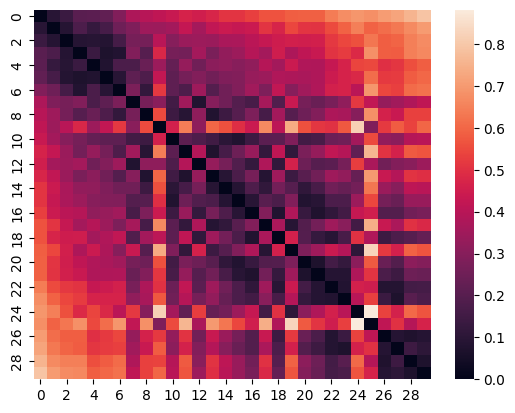

In [13]:
df2 = pd.DataFrame(testset_mat[ind])
sns.heatmap(data=df2)


<Axes: >

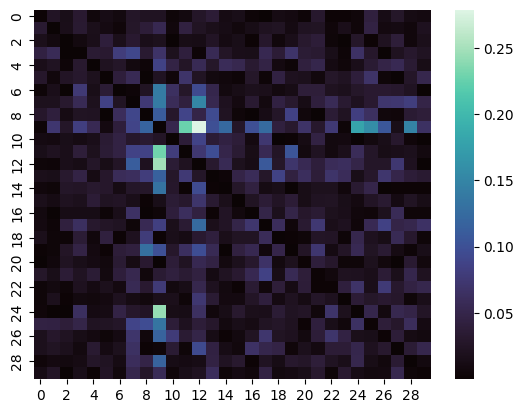

In [14]:
df3 = pd.DataFrame(abs(testset_mat[ind] - decoded_test[ind]))
sns.heatmap(data=df3, cmap="mako")


## Alternative coordinates reconstructor
Another way to achieve coordinates from the distance matrix is through a more analytical method that does not involve Machine Learning

Step 1: retrieve coordinates from distance matrix (shifted and rotated)

In [15]:
def gram_to_coordinates(distance_matrix):
    # Get the number of points
    n = distance_matrix.shape[0]

    # Compute the Gram matrix
    gram_matrix = -0.5 * (distance_matrix**2)

    # Center the Gram matrix
    gram_matrix_centered = (
        gram_matrix
        - np.mean(gram_matrix, axis=0)
        - np.mean(gram_matrix, axis=1)[:, np.newaxis]
        + np.mean(gram_matrix)
    )

    # Perform eigendecomposition of the centered Gram matrix
    eigenvalues, eigenvectors = np.linalg.eigh(gram_matrix_centered)

    # Sort eigenvalues and eigenvectors in descending order
    indices = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[indices]
    eigenvectors = eigenvectors[:, indices]

    # Extract the positive square root of eigenvalues
    sqrt_eigenvalues = np.sqrt(np.maximum(eigenvalues, 0))

    # Compute the coordinates of the points in 2D space
    coordinates = eigenvectors[:, :2] * sqrt_eigenvalues[:2]

    return coordinates

In [16]:
coordinates = gram_to_coordinates(decoded_train[1])
print("Coordinates of points:")
print(coordinates)


Coordinates of points:
[[-0.30113876  0.14729166]
 [-0.23580989  0.09936482]
 [-0.30588448  0.04498542]
 [-0.15580873  0.16553386]
 [-0.22351085  0.02909954]
 [-0.14745279  0.07889447]
 [-0.27994865 -0.04584545]
 [-0.14480531  0.01036052]
 [-0.07782002  0.08007971]
 [-0.22226946 -0.08583803]
 [-0.01932773  0.13145031]
 [-0.15914087 -0.0993684 ]
 [-0.05073047 -0.02455018]
 [ 0.00155313  0.01514854]
 [-0.06324681 -0.10055084]
 [ 0.07147729  0.08971445]
 [ 0.02503814 -0.06473108]
 [-0.0052155  -0.13005237]
 [ 0.13175185  0.07801031]
 [ 0.14488451  0.01516516]
 [ 0.0978823  -0.10390884]
 [-0.15762778 -0.31998917]
 [ 0.21750885  0.10834196]
 [ 0.16001827 -0.1009711 ]
 [ 0.23931131  0.03203354]
 [ 0.2485237  -0.04888099]
 [ 0.30261478  0.09795936]
 [ 0.19994791 -0.20044279]
 [ 0.32679155 -0.00615374]
 [ 0.375567    0.08440111]]


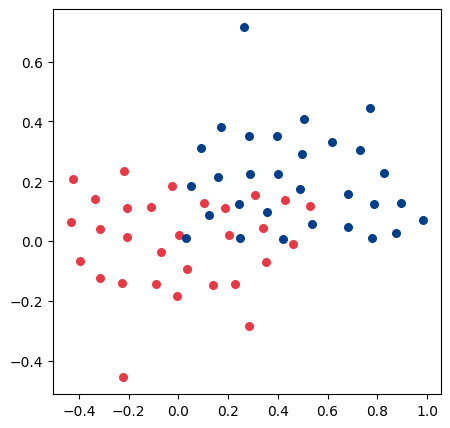

In [17]:
ind = 1
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot()
l = np.sqrt(2)
ax.scatter(
    coordinates[:, 0] * l,
    coordinates[:, 1] * l,
    s=30,
    c="#e63946",
)
ax.scatter(
    trainset_conf[ind, :, 0] * l,
    trainset_conf[ind, :, 1] * l,
    s=30,
    c="#023e8a",
)

In [18]:
def align_points(points1, points2):
    # Center the points by subtracting their means
    centered_points1 = points1 - np.mean(points1, axis=0)
    centered_points2 = points2 - np.mean(points2, axis=0)

    # Compute the covariance matrix
    covariance_matrix = centered_points2.T @ centered_points1

    # Perform singular value decomposition (SVD)
    U, _, Vt = np.linalg.svd(covariance_matrix)

    # Calculate the optimal rotation matrix
    rotation_matrix = Vt.T @ U.T

    # Calculate the optimal translation vector
    translation_vector = np.mean(points2, axis=0) - np.mean(
        points1 @ rotation_matrix, axis=0
    )

    # Transform points1 using the estimated rotation and translation
    transformed_points = points1 @ rotation_matrix + translation_vector

    return transformed_points

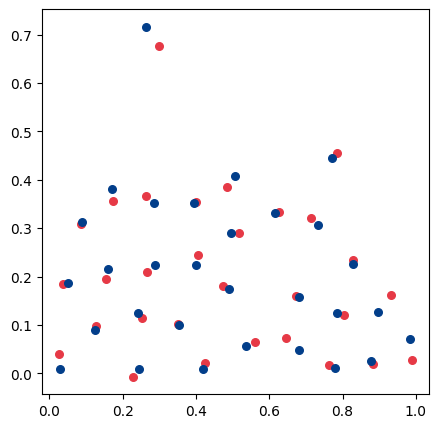

In [19]:
coordinates = align_points(coordinates, trainset_conf[1])
ind = 1
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot()
l = np.sqrt(2)
ax.scatter(
    coordinates[:, 0] * l,
    coordinates[:, 1] * l,
    s=30,
    c="#e63946",
)
ax.scatter(
    trainset_conf[ind, :, 0] * l,
    trainset_conf[ind, :, 1] * l,
    s=30,
    c="#023e8a",
)

In [20]:
rec_test_dec = np.zeros((testset_conf.shape))
for i in range(0, len(rec_test_dec)):
    rec_test_dec[i] = align_points(
        gram_to_coordinates(decoded_test[i]), testset_conf[i]
    )

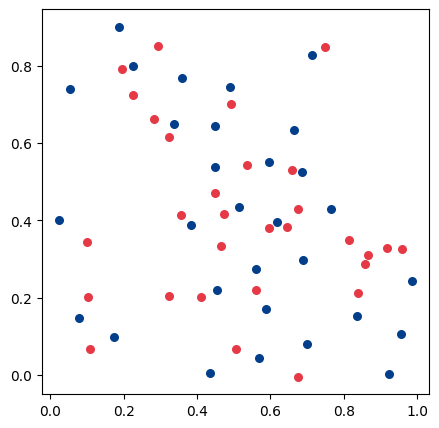

In [21]:
ind = 70
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot()
l = np.sqrt(2)
ax.scatter(
    rec_test_dec[ind, :, 0] * l,
    rec_test_dec[ind, :, 1] * l,
    s=30,
    c="#e63946",
)
ax.scatter(
    testset_conf[ind, :, 0] * l,
    testset_conf[ind, :, 1] * l,
    s=30,
    c="#023e8a",
)


## Deez Labels

In [22]:
import sklearn
from sklearn.decomposition import PCA


def label_vis(vae, encoded_data, labels):
    pca = PCA(n_components=2)
    transformed_data = pca.fit_transform(encoded_data[0, :, :])
    variance_ratio = pca.explained_variance_ratio_
    print(variance_ratio)

    # plot
    plt.figure(figsize=(5, 5))
    plt.scatter(transformed_data[:, 0], transformed_data[:, 1], c=labels, alpha=0.5)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()


[0.04508574 0.04142335]


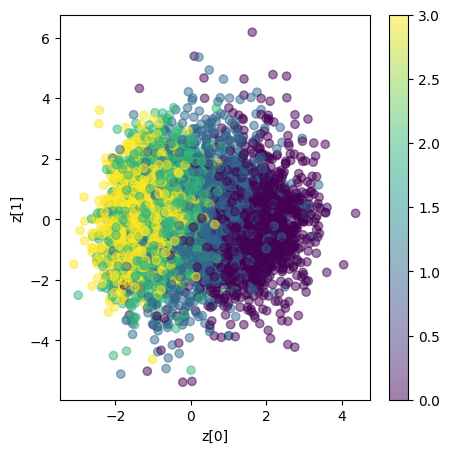

In [23]:
test_labels = labels[m_training:]
label_vis(vae, encoded_test, test_labels)

## Energy test

In [24]:
def potential(x, gamma):
    """
    Calculate LJ + gravitational potential given a positions array.

    INPUTS
        x: array of shape (num_particles, dimension)
        gamma
    """

    n = len(x)
    pot = 0.0
    for i in range(n - 1):
        pot += gamma * x[i, -1]
        for j in range(i + 1, n):
            r2 = np.sum((x[i, :] - x[j, :]) ** 2)
            if r2 < 1.0:
                continue
            if r2 < 9.0:  # r_cut = 3 sigma
                sr6 = 1.0 / r2**3
                pot += 4 * (sr6**2 - sr6)
    pot += gamma * x[-1, -1]

    return pot

In [25]:
scale_factor = box_size * np.sqrt(dim)
ori_pots = [
    potential(sample, gamma[labels[idx]])
    for idx, sample in enumerate(testset_conf * scale_factor)
]
rec_pots = [
    potential(sample, gamma[labels[idx]])
    for idx, sample in enumerate(rec_test_dec * scale_factor)
]


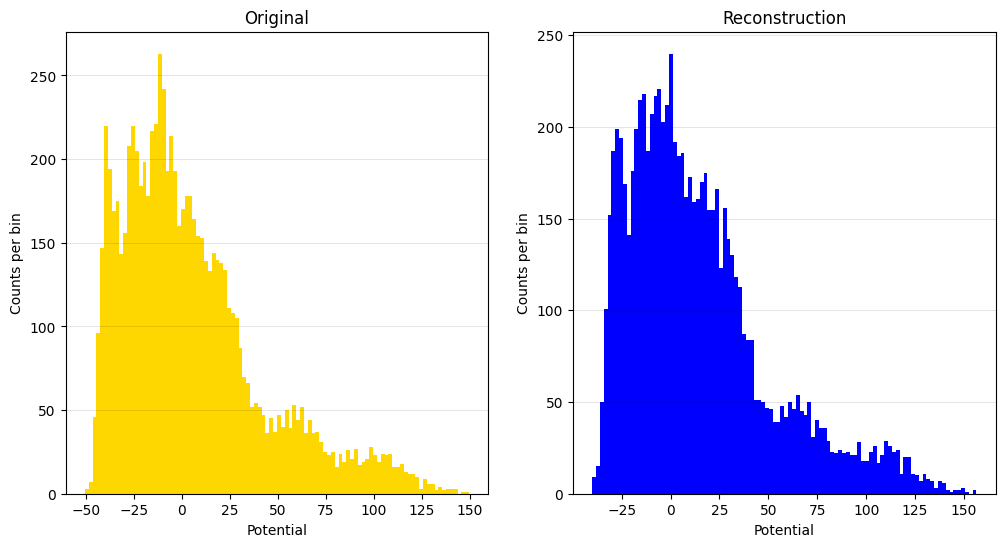

In [26]:
nbins = 100

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
ori_n, ori_bins, _ = ax[0].hist(ori_pots, bins=nbins, facecolor="gold")
ax[0].set_title("Original")
rec_n, rec_bins, _ = ax[1].hist(rec_pots, bins=nbins, facecolor="blue")
ax[1].set_title("Reconstruction")


for i in range(2):
    ax[i].set_xlabel("Potential")
    ax[i].set_ylabel("Counts per bin")
    ax[i].grid(axis="y", alpha=0.1, color="black")


Now we will compare the two distributions by calculating their Jensen–Shannon divergence, a symmetrized version of the Kullback–Leibler divergence, defined as

$$
    \operatorname{JSD}(P \:\Vert\: Q) = \frac{1}{2} D(P \:\Vert\: M)
        + \frac{1}{2} D(Q \:\Vert\: M),
$$

where $D$ is the usual Kullback–Leibler and $M = (P + Q) / 2$. $P$ and $Q$ must be normalized probability density functions: in our case they will be the bin heights of the previous histograms.

In [27]:
from scipy.spatial.distance import jensenshannon


def jsd(p, q):
    """
    Returns the Jensen-Shannon divergence of two datasets.
    """

    p = np.asarray(p, dtype="float")
    q = np.asarray(q, dtype="float")

    # get optimal bin edges ("fd" tries to minimize the integral
    # of the squared difference between the histogram and
    # the theoretical pdf)
    rng_pq = (min(np.min(p), np.min(q)), max(np.max(p), np.max(q)))
    dxp = np.histogram_bin_edges(p, bins="fd", range=rng_pq)
    dxq = np.histogram_bin_edges(q, bins="fd", range=rng_pq)

    nb = max(len(dxp), len(dxq))
    dx = min(np.diff(dxp)[0], np.diff(dxq)[0])

    p, _ = np.histogram(p, bins=nb, range=rng_pq)
    q, _ = np.histogram(q, bins=nb, range=rng_pq)

    # jensenshannon from scipy normalizes p, q automatically
    return jensenshannon(p, q)


In [28]:
jsd(ori_pots, rec_pots)


0.18895961694607374

## Generating from an untrained $\gamma$

In [29]:
untr_file = "impostor_gamma_3.txt"
untr_gamma = 3

untr_data = np.loadtxt(untr_file).reshape((-1, numpart, dim)) / (box_size * np.sqrt(dim))
m_untr = len(untr_data)
untr_labels = np.asarray([untr_gamma] * m_untr)

sort_idx = np.argsort(untr_data[:, :, 0]**2 + untr_data[:, :, 1]**2)
untr_data = np.asarray([sample[sort_idx[i]] for i, sample in enumerate(untr_data)])

untr_dm = np.asarray([squareform(pdist(sample)) for sample in untr_data], dtype="float")

encoded_untr = np.asarray(vae.encoder.predict(untr_dm), dtype="float")
print(encoded_untr.shape)

decoded_untr = np.asarray(decoder.predict(encoded_untr[2, :, :]), dtype="float").reshape(
    -1, numpart, numpart
)
print(decoded_untr.shape)

In [31]:
def untr_label_vis(vae, encoded_data, encoded_untr_data, labels, n_comp):
    pca = PCA(n_components=n_comp)
    transformed_data = pca.fit_transform(encoded_data[0, :, :])
    variance_ratio = pca.explained_variance_ratio_
    print(variance_ratio)

    untr_pca = PCA(n_components=n_comp)
    untr_transformed_data = untr_pca.fit_transform(encoded_untr_data[0, :, :])
    untr_variance_ratio = untr_pca.explained_variance_ratio_
    print(untr_variance_ratio)

    if (n_comp == 2):
        plt.figure(figsize=(10, 10))
        plt.scatter(transformed_data[:, 0], transformed_data[:, 1], c=labels, alpha=0.5)
        plt.scatter(untr_transformed_data[:, 0], untr_transformed_data[:, 1], c="red", alpha=0.5)
        plt.xlabel("z[0]")
        plt.ylabel("z[1]")
        plt.show()
    elif (n_comp == 3):
        fig = plt.figure(figsize=(10, 10))
        ax = fig.add_subplot(projection="3d")
        ax.scatter(transformed_data[:, 0], transformed_data[:, 1], transformed_data[:, 2], c=labels, alpha=0.5)
        ax.scatter(untr_transformed_data[:, 0], untr_transformed_data[:, 1], untr_transformed_data[:, 2], c="red", alpha=0.5)
        ax.set_xlabel("z[0]")
        ax.set_ylabel("z[1]")
        ax.set_zlabel("z[2]")
        plt.show()


[0.044901   0.04144681]
[0.09509503 0.07215607]


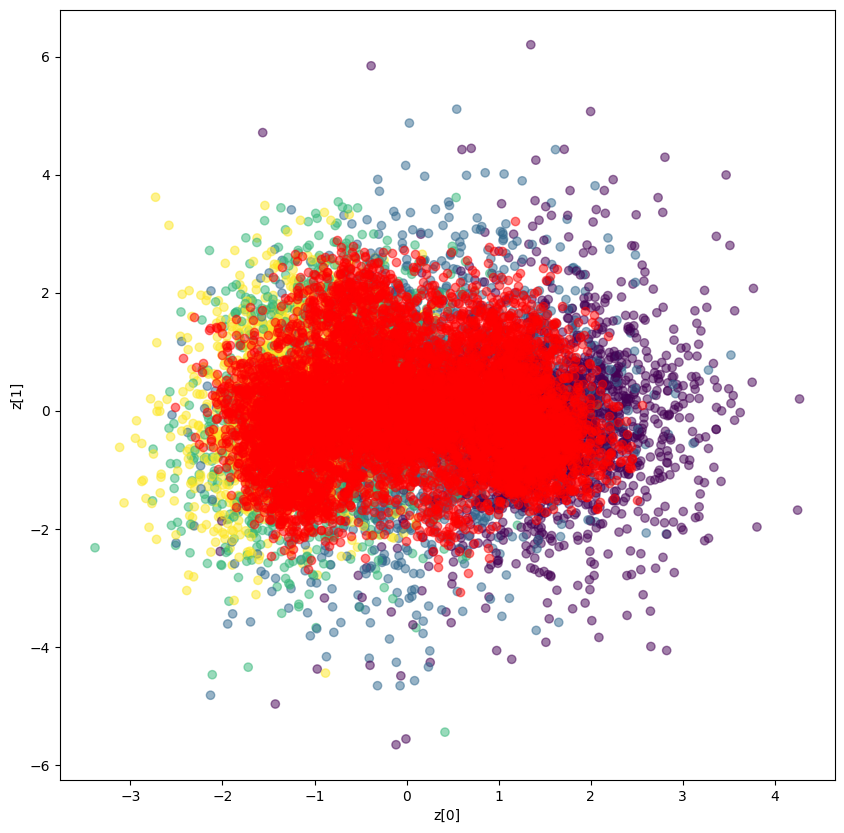

In [32]:
#from google.colab import output
#output.enable_custom_widget_manager()

#%matplotlib widget
untr_label_vis(vae, encoded_test[:, :m_untr, :], encoded_untr, test_labels[:m_untr], 2)

250/250 [==============================] - 32s 126ms/step


In [1]:
#output.disable_custom_widget_manager()

diff = np.abs(decoded_untr - untr_dm) / untr_dm
df = pd.DataFrame(diff[1])
sns.heatmap(df, cmap="mako")


NameError: ignored